# Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression, make_classification
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import cross_validation
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier

import xgboost

from geopy.distance import vincenty
from datetime import datetime as dt
from haversine import haversine
from sklearn.decomposition import PCA

/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Loading the Data

In [2]:
pd.set_option('max_columns', 100)
pd.set_option('max_colwidth', 999)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.precision',10)

In [3]:
train = pd.read_csv('train.csv')
weather = pd.read_csv('weather.csv')
spray = pd.read_csv('spray.csv')

weather = weather.iloc[56:]

In [4]:
def choose_station(lat, long):
    dist_ohare = abs((41.995 - lat) + (-87.933 - long))
    dist_midway = abs((41.786 - lat) + (-87.752 - long)) 
    if dist_ohare < dist_midway:
        return 1
    else:
        return 2

In [5]:
train['Station'] = train.apply(lambda x: choose_station(x['Latitude'], x['Longitude']), axis=1)

In [6]:
# Spray data in case we choose to pursue it
spray['Date'] = pd.to_datetime(spray['Date'])
spray.duplicated().sum()
spray.drop_duplicates(inplace=True)

In [7]:
train = pd.merge(train, weather, on=['Date','Station'])

# EDA & Cleaning

In [8]:
le = LabelEncoder()
#train.drop('Species', axis=1, inplace=True)
le.fit(train['Species'])
train['Species'] = le.transform(train['Species'])
le.fit(train['Trap'])
train['Trap'] = le.transform(train['Trap'])
le.fit(train['Water1'])
train['Water1'] = le.transform(train['Water1'])

train.replace('M', np.NaN, inplace=True, axis=1)
train.replace('  T', np.NaN, inplace=True, axis=1)

train['Sunrise'].replace('-', np.nan, inplace=True, axis=1)
train['Sunrise'].fillna(str('0421'), inplace=True)
train['Sunset'].replace('-', np.nan, inplace=True, axis=1)
train['Sunset'].fillna(1919, inplace=True)
train['CodeSum'].replace(r'^\s*$', 'Moderate', regex=True, inplace=True, axis=1)

train['Tavg'] = train['Tavg'].astype('float64')
train['Depart'] = train['Depart'].astype('float64')
train['WetBulb'] = train['WetBulb'].astype('float64')
train['Depth'] = train['Depth'].astype('float64')
train['SnowFall'] = train['SnowFall'].astype('float64')
train['PrecipTotal'] = train['PrecipTotal'].astype('float64')
train['StnPressure'] = train['StnPressure'].astype('float64')
train['SeaLevel'] = train['SeaLevel'].astype('float64')
train['AvgSpeed'] = train['AvgSpeed'].astype('float64')
train['Heat'] = train['Heat'].astype('int64')
train['Cool'] = train['Cool'].astype('int64')
train['Sunrise'] = train['Sunrise'].astype('int64')
train['Sunset'] = train['Sunset'].astype('int64')

train['Depth'].interpolate(method='linear', inplace=True)
train['SnowFall'].interpolate(method='linear', inplace=True)
train['PrecipTotal'].interpolate(method='linear', inplace=True)
train['StnPressure'].interpolate(method='linear', inplace=True)
train['Depart'].interpolate(method='linear', inplace=True)
train['WetBulb'].interpolate(method='linear', inplace=True)

# Replace all TSRA (thunderstorm + rain) with 'TR' to be able to better split values
train['CodeSum'] = train['CodeSum'].map(lambda x: (x.replace('TSRA', 'TR')))
train['CodeSum_1'] = train['CodeSum'].apply(lambda x: x[0:2])
train['CodeSum_2'] = train['CodeSum'].apply(lambda x: x[3:5])

le.fit(train['CodeSum_1'])
train['CodeSum_1'] = le.transform(train['CodeSum_1'])
le.fit(train['CodeSum_2'])
train['CodeSum_2'] = le.transform(train['CodeSum_2'])

# train['Rain'] = train['CodeSum'].apply(lambda x: 1 if "RA" in x else 0)
# train['Rain'] = train['CodeSum'].apply(lambda x: 1 if "TS" in x else 0)
# train['Rain'] = train['CodeSum'].apply(lambda x: 1 if "DZ" in x else 0)
# train['Moderate'] = train['CodeSum'].apply(lambda x: 1 if 'Mod' in x else 0)

train['Year'] = train['Date'].apply(lambda x: x[0:4])
train = pd.get_dummies(train, columns=['Year'])

# Reinstantiating column as it was deleted in get_dummies
train['Year'] = train['Date'].apply(lambda x: x[0:4])
train['Year'] = train['Year'].astype('int64')
train['OverAvgNumMos'] = train['NumMosquitos'].apply(lambda x: 1 if x >= 13 else 0)

/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4480: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warnings.warn('the "axis" argument is deprecated '


In [9]:
wnv = train.loc[train['WnvPresent'] ==1]

In [10]:
train.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Station', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'CodeSum_1',
       'CodeSum_2', 'Year_2007', 'Year_2009', 'Year_2011', 'Year_2013', 'Year',
       'OverAvgNumMos'],
      dtype='object')

In [11]:
# train2 = train.groupby(['Date', 'Address', 'Block', 'Street', 'Trap',
#        'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
#        'NumMosquitos', 'WnvPresent', 'Station', 'Tmax', 'Tmin', 'Tavg',
#        'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
#        'CodeSum', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure',
#        'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'CodeSum_1',
#        'CodeSum_2']).agg({'Species':', '.sum}).reset_index()

# Identifying Clusters

In [17]:
present = train.loc[train['WnvPresent'] == 1]

train['Longitude_wnv'] = present['Longitude']
train['Latitude_wnv'] = present['Latitude']
train['2007_wnv'] = present['Year_2007']
train['2009_wnv'] = present['Year_2009']
train['2011_wnv'] = present['Year_2011']
train['2013_wnv'] = present['Year_2013']

train['2007_wnv'].fillna(0, inplace = True)
train['2009_wnv'].fillna(0, inplace = True)
train['2011_wnv'].fillna(0, inplace = True)
train['2013_wnv'].fillna(0, inplace = True)

In [18]:
wnv_present_2007 = train.loc[train['2007_wnv'] == 1]

train['Longitude_wnv_2007'] = wnv_present_2007['Longitude']
train['Latitude_wnv_2007'] = wnv_present_2007['Latitude']
train['Longitude_wnv_2007'].fillna(0, inplace = True)
train['Latitude_wnv_2007'].fillna(0, inplace = True)

wnv_present_2009 = train.loc[train['2009_wnv'] == 1]

train['Longitude_wnv_2009'] = wnv_present_2009['Longitude']
train['Latitude_wnv_2009'] = wnv_present_2009['Latitude']
train['Longitude_wnv_2009'].fillna(0, inplace = True)
train['Latitude_wnv_2009'].fillna(0, inplace = True)

wnv_present_2011 = train.loc[train['2011_wnv'] == 1]

train['Longitude_wnv_2011'] = wnv_present_2011['Longitude']
train['Latitude_wnv_2011'] = wnv_present_2011['Latitude']
train['Longitude_wnv_2011'].fillna(0, inplace = True)
train['Latitude_wnv_2011'].fillna(0, inplace = True)

wnv_present_2013 = train.loc[train['2013_wnv'] == 1]

train['Longitude_wnv_2013'] = wnv_present_2013['Longitude']
train['Latitude_wnv_2013'] = wnv_present_2013['Latitude']
train['Longitude_wnv_2013'].fillna(0, inplace = True)
train['Latitude_wnv_2013'].fillna(0, inplace = True)

   Longitude_2007  Latitude_2007
1         -87.580         41.696
2         -87.684         41.911
3         -87.707         41.800
4         -87.798         41.975
5         -87.687         41.698
Silhouette Score:  0.9902899479522004


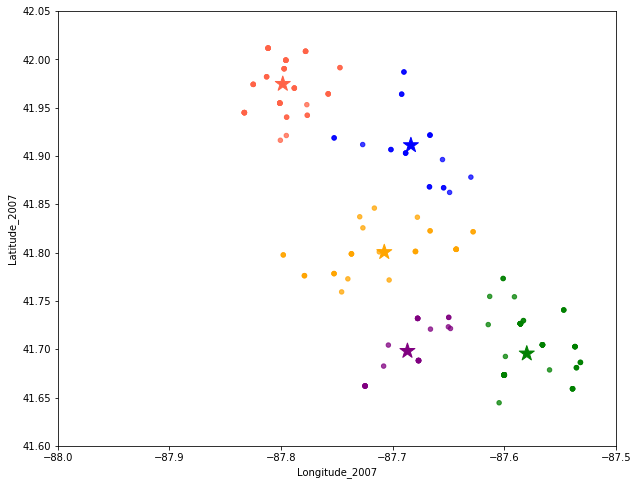

In [19]:
kmeans_2007 = KMeans(n_clusters=6)
model_2007 = kmeans_2007.fit(train[['Longitude_wnv_2007', 'Latitude_wnv_2007']])
train['cluster_predicted_2007'] = model_2007.labels_
model_2007.cluster_centers_
centroids_2007 = pd.DataFrame(model_2007.cluster_centers_, columns=['Longitude_2007', 'Latitude_2007'])
centroids_2007.drop([0], inplace=True)
print(centroids_2007)

colors = ["black", "green", "blue", "orange", "tomato", "purple"] # black is for non-present WNV
train['cluster_color_2007'] = train['cluster_predicted_2007'].map(lambda p: colors[p])

ax = train.plot(kind="scatter", 
    x="Longitude_wnv_2007", y="Latitude_wnv_2007",
    figsize=(10,8),
    xlim=(-88, -87.5),
    ylim=(41.6, 42.05),
    c = train['cluster_color_2007'],
    alpha=0.75)

centroids_2007.plot(kind="scatter", 
    x="Longitude_2007", y="Latitude_2007", 
    marker="*", 
    c=["green", "blue", "orange", "tomato", "purple"], 
    s=250,
    ax=ax)

print('Silhouette Score: ', silhouette_score(train[['Longitude_wnv_2007', 'Latitude_wnv_2007']], 
                                             train['cluster_predicted_2007']))

   Longitude_2009  Latitude_2009
1         -87.780         41.936
2         -87.572         41.705
3         -87.722         41.727
4         -87.901         41.971
5         -87.678         41.886
Silhouette Score:  0.9990879006533443


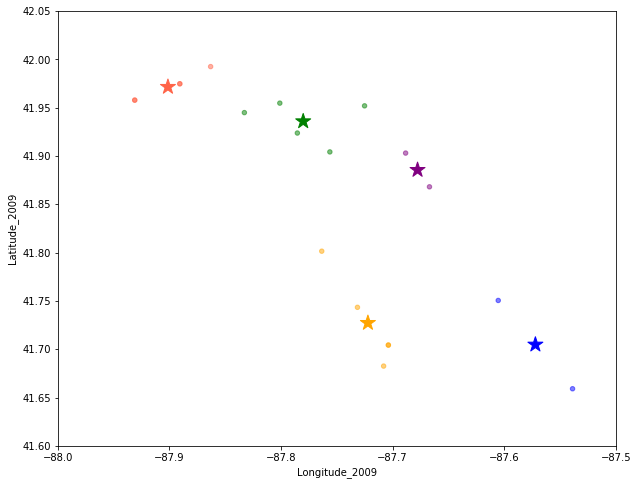

In [20]:
kmeans_2009 = KMeans(n_clusters=6)
model_2009 = kmeans_2009.fit(train[['Longitude_wnv_2009', 'Latitude_wnv_2009']])
train['cluster_predicted_2009'] = model_2009.labels_
model_2009.cluster_centers_
centroids_2009 = pd.DataFrame(model_2009.cluster_centers_, columns=['Longitude_2009', 'Latitude_2009'])
centroids_2009.drop([0], inplace=True)
print(centroids_2009)

colors = ["black", "green", "blue", "orange", "tomato", "purple"] # black is for non-present WNV
train['cluster_color_2009'] = train['cluster_predicted_2009'].map(lambda p: colors[p])

ax = train.plot(kind="scatter", 
    x="Longitude_wnv_2009", y="Latitude_wnv_2009",
    figsize=(10,8),
    xlim=(-88, -87.5),
    ylim=(41.6, 42.05),
    c = train['cluster_color_2009'],
    alpha=0.5)

centroids_2009.plot(kind="scatter", 
    x="Longitude_2009", y="Latitude_2009", 
    marker="*", 
    c=["green", "blue", "orange", "tomato", "purple"], 
    s=250,
    ax=ax)

print('Silhouette Score: ', silhouette_score(train[['Longitude_wnv_2009', 'Latitude_wnv_2009']], 
                                             train['cluster_predicted_2009']))

   Longitude_2011  Latitude_2011
1         -87.903         41.969
2         -87.718         41.936
3         -87.730         41.753
4         -87.605         41.756
5         -87.789         41.960
Silhouette Score:  0.9979362952747243


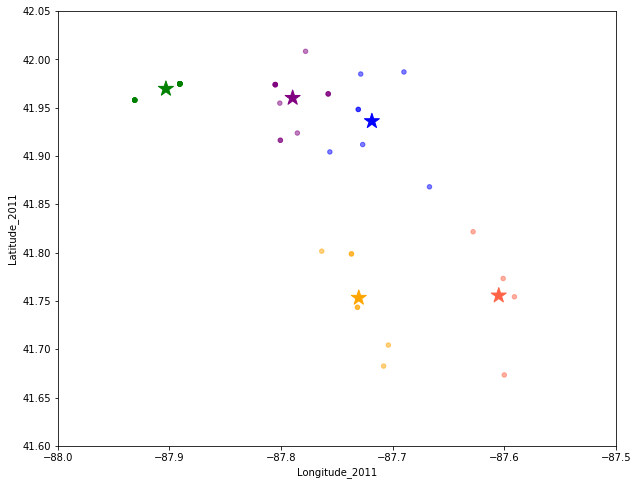

In [21]:
kmeans_2011 = KMeans(n_clusters=6)
model_2011 = kmeans_2011.fit(train[['Longitude_wnv_2011', 'Latitude_wnv_2011']])
train['cluster_predicted_2011'] = model_2011.labels_
model_2011.cluster_centers_
centroids_2011 = pd.DataFrame(model_2011.cluster_centers_, columns=['Longitude_2011', 'Latitude_2011'])
centroids_2011.drop([0], inplace=True)
print(centroids_2011)

colors = ["black", "green", "blue", "orange", "tomato", "purple"] # black is for non-present WNV
train['cluster_color_2011'] = train['cluster_predicted_2011'].map(lambda p: colors[p])

ax = train.plot(kind="scatter", 
    x="Longitude_wnv_2011", y="Latitude_wnv_2011",
    figsize=(10,8),
    xlim=(-88, -87.5),
    ylim=(41.6, 42.05),
    c = train['cluster_color_2011'],
    alpha=0.5)

centroids_2011.plot(kind="scatter", 
    x="Longitude_2011", y="Latitude_2011", 
    marker="*", 
    c=["green", "blue", "orange", "tomato", "purple"], 
    s=250,
    ax=ax)

print('Silhouette Score: ', silhouette_score(train[['Longitude_wnv_2011', 'Latitude_wnv_2011']], 
                                             train['cluster_predicted_2011']))

   Longitude_2013  Latitude_2013
1         -87.698         41.929
2         -87.726         41.763
3         -87.888         41.976
4         -87.617         41.739
5         -87.790         41.965
Silhouette Score:  0.9891512919774651


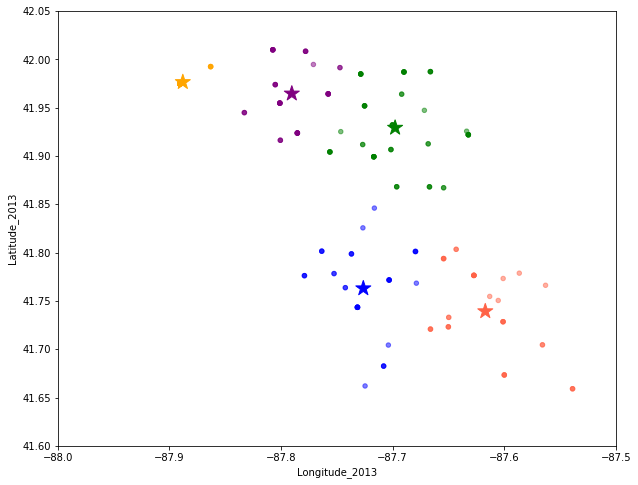

In [22]:
kmeans_2013 = KMeans(n_clusters=6)
model_2013 = kmeans_2013.fit(train[['Longitude_wnv_2013', 'Latitude_wnv_2013']])
train['cluster_predicted_2013'] = model_2013.labels_
model_2013.cluster_centers_
centroids_2013 = pd.DataFrame(model_2013.cluster_centers_, columns=['Longitude_2013', 'Latitude_2013'])
centroids_2013.drop([0], inplace=True)
print(centroids_2013)

colors = ["black", "green", "blue", "orange", "tomato", "purple"] # black is for non-present WNV
train['cluster_color_2013'] = train['cluster_predicted_2013'].map(lambda p: colors[p])

ax = train.plot(kind="scatter", 
    x="Longitude_wnv_2013", y="Latitude_wnv_2013",
    figsize=(10,8),
    xlim=(-88, -87.5),
    ylim=(41.6, 42.05),
    c = train['cluster_color_2013'],
    alpha=0.5)

centroids_2013.plot(kind="scatter", 
    x="Longitude_2013", y="Latitude_2013", 
    marker="*", 
    c=["green", "blue", "orange", "tomato", "purple"], 
    s=250,
    ax=ax)

print('Silhouette Score: ', silhouette_score(train[['Longitude_wnv_2013', 'Latitude_wnv_2013']],
                                             train['cluster_predicted_2013']))

# Functions for new features

In [23]:
seven_centroids= [(-87.580, 41.696), (-87.797, 41.973), (-87.707, 41.800), (-87.677, 41.910), (-87.687, 41.698)]
seven_centroids = [t[::-1] for t in seven_centroids]
nine_centroids = [(41.932, -87.794),(41.727, -87.722),(41.971, -87.901),(41.705, -87.572),(41.908, -87.693)]
eleven_centroids= [(-87.718, 41.936), (-87.903,41.969),(-87.730, 41.753),(-87.605, 41.756),(-87.789, 41.960)]
eleven_centroids = [t[::-1] for t in eleven_centroids]
thirteen_centroids = [(-87.688, 41.925), (-87.888, 41.976), (-87.617, 41.739), (-87.726, 41.763), (-87.780, 41.961)]
thirteen_centroids = [t[::-1] for t in thirteen_centroids]

In [24]:
seven_traps = train.loc[train['Year']== 2007]
seven_traps = seven_traps[['Latitude', 'Longitude']]
seven_tuples = [tuple(x) for x in seven_traps.values]

nine_traps = train.loc[train['Year']== 2009]
nine_traps = nine_traps[['Latitude', 'Longitude']]
nine_tuples = [tuple(x) for x in nine_traps.values]

eleven_traps = train.loc[train['Year']== 2011]
eleven_traps = eleven_traps[['Latitude', 'Longitude']]
eleven_tuples = [tuple(x) for x in eleven_traps.values]

thirteen_traps = train.loc[train['Year']== 2013]
thirteen_traps = thirteen_traps[['Latitude', 'Longitude']]
thirteen_tuples = [tuple(x) for x in thirteen_traps.values]

all_tuples = train[["Latitude", "Longitude"]]
all_tuples = [tuple(x) for x in all_tuples.values]

In [25]:
within_range_7 = []
def impossible_haversine_attempt_2007(a, b):
    
    for coord in a:
        for centroid in b:
            if haversine(coord, centroid, miles=True) < 0.35:
                within_range_7.append(coord)
            else:
                pass
            
    return('done!')

In [26]:
within_range_9 = []
def impossible_haversine_attempt_2009(a, b):
    for coord in a:
        for centroid in b:
            if haversine(coord, centroid, miles=True) < 0.35:
                within_range_9.append(coord)
            else:
                pass
            
    return('done!')

In [27]:
within_range_11 = []
def impossible_haversine_attempt_2011(a, b):
    for coord in a:
        for centroid in b:
            if haversine(coord, centroid, miles=True) < 0.35:
                within_range_11.append(coord)
            else:
                pass
            
    return('done!')

In [28]:
within_range_13 = []
def impossible_haversine_attempt_2013(a, b):
    for coord in a:
        for centroid in b:
            if haversine(coord, centroid, miles=True) < 0.35:
                within_range_13.append(coord)
            else:
                pass
            
    return('done!')

In [29]:
impossible_haversine_attempt_2007(seven_tuples, seven_centroids)

impossible_haversine_attempt_2009(nine_tuples, nine_centroids)

impossible_haversine_attempt_2011(eleven_tuples, eleven_centroids)

impossible_haversine_attempt_2013(thirteen_tuples, thirteen_centroids)

'done!'

In [30]:
train['LLtuples'] = all_tuples

train['Near_07_Centroid'] = train['LLtuples'].apply(lambda x: 1 if x in within_range_7 else 0)
train['Near_09_Centroid'] = train['LLtuples'].apply(lambda x: 1 if x in within_range_9 else 0)
train['Near_11_Centroid'] = train['LLtuples'].apply(lambda x: 1 if x in within_range_11 else 0)
train['Near_13_Centroid'] = train['LLtuples'].apply(lambda x: 1 if x in within_range_13 else 0)

# Modeling

In [31]:
nm = train.drop(['Year_2007', 'Year_2009', 'Year_2011', 'Year_2013', 'Year',
       'Longitude_wnv', 'Latitude_wnv', '2007_wnv', '2009_wnv', '2011_wnv',
       '2013_wnv', 'Longitude_wnv_2007', 'Latitude_wnv_2007',
       'Longitude_wnv_2009', 'Latitude_wnv_2009', 'Longitude_wnv_2011',
       'Latitude_wnv_2011', 'Longitude_wnv_2013', 'Latitude_wnv_2013',
       'cluster_predicted_2009', 'cluster_color_2009',
       'cluster_predicted_2013', 'cluster_color_2013', 'Date', 'Address', 'Street', 
       'AddressNumberAndStreet','LLtuples', 'CodeSum',  'cluster_predicted_2007', 'cluster_color_2007',
       'cluster_predicted_2011', 'cluster_color_2011', 'Depth', 'SnowFall', 'Water1', 'ResultSpeed', 'Station', 
        'Sunrise', 'StnPressure', 'Near_07_Centroid', 'Near_09_Centroid', 'Near_11_Centroid',
       'Near_13_Centroid', 'WnvPresent', 'ResultDir', 'CodeSum_1', 'CodeSum_2', 'Longitude', 'PrecipTotal', 'SeaLevel',
        'AvgSpeed', 'Species'], axis=1)


In [32]:
nmfeatures = nm.drop(['NumMosquitos', 'OverAvgNumMos'], axis=1)

In [33]:
nmfeatures.columns

Index(['Block', 'Trap', 'Latitude', 'AddressAccuracy', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunset'],
      dtype='object')

In [34]:
nm.corr()['OverAvgNumMos'].sort_values(ascending=False)

OverAvgNumMos      1.000
NumMosquitos       0.860
Tmin               0.163
Tavg               0.161
WetBulb            0.153
Cool               0.152
Tmax               0.140
DewPoint           0.138
Trap               0.121
Depart             0.085
Sunset             0.072
Heat              -0.124
Block             -0.124
Latitude          -0.125
AddressAccuracy   -0.164
Name: OverAvgNumMos, dtype: float64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(nmfeatures, nm['OverAvgNumMos'], train_size=0.6)

/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [36]:
scaler =StandardScaler()
pcacopy =PCA()
mosgb = GradientBoostingClassifier()
ada = AdaBoostClassifier()
rfr = RandomForestClassifier()
xgb = xgboost.XGBClassifier()

In [37]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pcacopy.fit_transform(X_train)
X_test = pcacopy.transform(X_test)

In [39]:
mosgb.fit(X_train, y_train)
print(mosgb.score(X_train, y_train))
print(mosgb.score(X_test, y_test))

0.8077106139933365
0.7687366167023555


In [40]:
ada.fit(X_train, y_train)
print(ada.score(X_train, y_train))
print(ada.score(X_test, y_test))

0.7699508170712359
0.7466095645967167


In [41]:
rfr.fit(X_train, y_train)
print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

0.9132159289227352
0.7706400190340233


In [42]:
xgb.fit(X_train, y_train)
print(xgb.score(X_train, y_train))
print(xgb.score(X_test, y_test))

0.8043788672060923
0.7696883178681894


/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [45]:
# from keras import regularizers
# from keras.callbacks import EarlyStopping

# nmodel = Sequential()

# n_input = X_train.shape[1]
# n_hidden = n_input
# n_output = 1

# nmodel.add(Dense(n_hidden, input_dim=n_input, activation='relu',
#                   kernel_regularizer=regularizers.l2(0.001)))
# nmodel.add(Dropout(.25))

# nmodel.add(Dense(4, activation= 'relu', 
#                    kernel_regularizer=regularizers.l2(0.001)))
# nmodel.add(Dropout(.25))

# nmodel.add(Dense(1))

In [46]:
# nmodel.compile(loss='mean_squared_error', optimizer='adam')
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [47]:
# history = nmodel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=None, callbacks =[early_stop])

In [48]:
# train_loss =history.history['loss']
# test_loss = history.history['val_loss']
# plt.plot(train_loss, label='training loss')
# plt.plot(test_loss, label='test loss')
# plt.legend()

# Creating a padded DF, compensating for rows that duplicate by species per trap, and giving a lot more Wnv samples to analyze, maybe??? Overfitting but there are 551 unique samples * 4

In [49]:
wnv_samples_1 = train[train['WnvPresent'] ==1]
wnv_samples_2 = train[train['WnvPresent'] ==1]
wnv_samples_3 = train[train['WnvPresent'] ==1]
wnv_samples_4 = train[train['WnvPresent'] ==1]

In [50]:
frames = [train, wnv_samples_1, wnv_samples_2, wnv_samples_3, wnv_samples_4]

pad_train = pd.concat(frames)
pad_train.reset_index(inplace=True)

In [51]:
pad_train.drop(['Year_2007', 'Year_2009', 'Year_2011', 'Year_2013', 'Year',
       'Longitude_wnv', 'Latitude_wnv', '2007_wnv', '2009_wnv', '2011_wnv',
       '2013_wnv', 'Longitude_wnv_2007', 'Latitude_wnv_2007',
       'Longitude_wnv_2009', 'Latitude_wnv_2009', 'Longitude_wnv_2011',
       'Latitude_wnv_2011', 'Longitude_wnv_2013', 'Latitude_wnv_2013',
       'cluster_predicted_2009', 'cluster_color_2009',
       'cluster_predicted_2013', 'cluster_color_2013', 'Date', 'Address', 'Street', 
       'AddressNumberAndStreet','LLtuples', 'CodeSum', 'index',  'cluster_predicted_2007', 'cluster_color_2007',
       'cluster_predicted_2011', 'cluster_color_2011', 'NumMosquitos'], axis=1, inplace= True)

In [52]:
pad_train.columns

Index(['Species', 'Block', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
       'WnvPresent', 'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth', 'Water1',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'CodeSum_1', 'CodeSum_2', 'OverAvgNumMos',
       'Near_07_Centroid', 'Near_09_Centroid', 'Near_11_Centroid',
       'Near_13_Centroid'],
      dtype='object')

In [53]:
# fig, ax = plt.subplots(figsize=(12,12))
# ax = sns.heatmap(features.corr(), annot= True)

In [54]:
#poly = PolynomialFeatures()
#features_poly = poly.fit_transform(features)
X = pad_train.drop('WnvPresent', axis=1)
y = pad_train['WnvPresent']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, stratify=y)

/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [56]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test= ss.transform(X_test)
pca = PCA(n_components=25)
X_train = pca.fit_transform(X_train)
X_test= pca.transform(X_test)
xgbmodel = xgboost.XGBClassifier()


In [57]:
xgbmodel.fit(X_train,y_train)
print(xgbmodel.score(X_train, y_train))
print(xgbmodel.score(X_test, y_test))

0.8648046157880933
0.8579858379228954


/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [58]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.9704956726986624
0.9508261211644374


In [59]:
xgbmodel = xgboost.XGBClassifier()
xgbmodel.fit(X_train, y_train)
print(xgbmodel.score(X_train, y_train))
print(xgbmodel.score(X_test, y_test))

0.8648046157880933
0.8579858379228954


/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [60]:
bayes = GaussianNB()
bayes.fit(X_train, y_train)
print(bayes.score(X_train, y_train))
print(bayes.score(X_test, y_test))

0.8013375295043274
0.8131392604248623


In [61]:
bag = BaggingClassifier()
bag.fit(X_train, y_train)
print(bag.score(X_train, y_train))
print(bag.score(X_test, y_test))

0.970889063729347
0.9451219512195121


In [138]:
gb = GradientBoostingClassifier(min_weight_fraction_leaf=.2)
gb.fit(X_train, y_train)
print(gb.score(X_train, y_train))
print(gb.score(X_test, y_test))

0.8401521111985314
0.837332808811959


In [65]:
params = {
  'learning_rate':[0.001, 0.002, 0.003, 0.004],
  'n_estimators' : [750, 1000, 1250, 1500],
  'max_features' : [8,9,10],
  'max_depth' : [6,7,8,9],
  'min_weight_fraction_leaf': [0.3, 0.4, 0.5]
    
    
}

gs = GridSearchCV(gb, params, verbose=1, cv=2)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

Fitting 2 folds for each of 576 candidates, totalling 1152 fits


[Parallel(n_jobs=1)]: Done 1152 out of 1152 | elapsed: 28.6min finished


0.8038290060319958
{'learning_rate': 0.004, 'max_depth': 8, 'max_features': 10, 'min_weight_fraction_leaf': 0.3, 'n_estimators': 1500}


In [66]:
gs.score(X_train, y_train)

0.8018620508785733

In [63]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
print(ada.score(X_train, y_train))
print(ada.score(X_test, y_test))

0.8370049829530554
0.8308418568056648


In [ ]:
# Setting random seed for NN (https://machinelearningmastery.com/reproducible-results-neural-networks-keras/)
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

def keras_gridsearch(hidden_layer_one=27, hidden_layer_two=20):
    model = Sequential()
    model.add(Dense(27, activation='relu', input_dim=X_train.shape[1])) 
    model.add(Dense(hidden_layer_one, activation='relu')) 
    model.add(Dense(hidden_layer_two, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# history = keras.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100)

In [380]:
ss_nn = StandardScaler()
keras = KerasClassifier(build_fn=keras_gridsearch, verbose=1)

pipe = Pipeline([
    ('ss', ss_nn),
    ('keras', keras)])

In [190]:
# params = {
#     'keras__epochs': [15],
#     'keras__batch_size': [50],
#     'keras__hidden_layer_one': [12, 15],
#     'keras__hidden_layer_two': [4, 8]
# }

# gs = GridSearchCV(pipe, params, verbose=1, cv=2)
# gs.fit(X_train, y_train)
# print(gs.best_score_)
# print(gs.best_params_)

# Applying to Validation Dataset

In [113]:
test = pd.read_csv('test.csv') #to get values for df 
sub =pd.read_csv('test.csv') # to get strip ids

In [114]:
test['Station'] = test.apply(lambda x: choose_station(x['Latitude'], x['Longitude']), axis=1)
test= pd.merge(test, weather, on=['Date','Station'])

In [115]:
#test.drop('Species', axis=1, inplace=True)
le.fit(test['Species'])
test['Species'] = le.transform(test['Species'])
le.fit(test['Trap'])
test['Trap'] = le.transform(test['Trap'])
le.fit(test['Water1'])
test['Water1'] = le.transform(test['Water1'])

test.replace('M', np.NaN ,inplace=True, axis = 1)
test.replace('  T', np.NaN ,inplace=True, axis = 1)
test['Sunrise'].replace('-', np.nan,inplace=True, axis = 1)
test['Sunrise'].fillna(str('0421'), inplace = True)
test['Sunset'].replace('-', np.nan,inplace=True, axis = 1)
test['Sunset'].fillna(1919, inplace = True)

test['Tavg'] = test['Tavg'].astype('float64')
test['Depart'] = test['Depart'].astype('float64')
test['WetBulb'] = test['WetBulb'].astype('float64')
test['Depth'] = test['Depth'].astype('float64')
test['SnowFall'] = test['SnowFall'].astype('float64')
test['PrecipTotal'] = test['PrecipTotal'].astype('float64')
test['StnPressure'] = test['StnPressure'].astype('float64')
test['SeaLevel'] = test['SeaLevel'].astype('float64')
test['AvgSpeed'] = test['AvgSpeed'].astype('float64')
test['Heat'] = test['Heat'].astype('int64')
test['Cool'] = test['Cool'].astype('int64')
test['Sunrise'] = test['Sunrise'].astype('int64')
test['Sunset'] = test['Sunset'].astype('int64')

test['Depth'].interpolate(method='linear', inplace=True)
test['SnowFall'].interpolate(method='linear', inplace=True)
test['PrecipTotal'].interpolate(method='linear', inplace=True)
test['StnPressure'].interpolate(method='linear', inplace=True)
test['Depart'].interpolate(method='linear', inplace=True)
test['WetBulb'].interpolate(method='linear', inplace=True)

test['CodeSum'] = test['CodeSum'].map(lambda x: (x.replace('TSRA', 'TR')))
test['CodeSum_1'] = test['CodeSum'].apply(lambda x: x[0:2])
test['CodeSum_2'] = test['CodeSum'].apply(lambda x: x[3:5])

le.fit(test['CodeSum_1'])
test['CodeSum_1'] = le.transform(test['CodeSum_1'])
le.fit(test['CodeSum_2'])
test['CodeSum_2'] = le.transform(test['CodeSum_2'])

test_tuples = test[["Latitude", "Longitude"]]
test_tuples = [tuple(x) for x in test_tuples.values]
test['LLtuples'] = test_tuples

test['Near_07_Centroid'] = test['LLtuples'].apply(lambda x: 1 if x in within_range_7 else 0)
test['Near_09_Centroid'] = test['LLtuples'].apply(lambda x: 1 if x in within_range_9 else 0)
test['Near_11_Centroid'] = test['LLtuples'].apply(lambda x: 1 if x in within_range_11 else 0)
test['Near_13_Centroid'] = test['LLtuples'].apply(lambda x: 1 if x in within_range_13 else 0)


/Users/adamkrauss/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4480: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warnings.warn('the "axis" argument is deprecated '


In [116]:
test.drop(['Date', 'Address', 'AddressNumberAndStreet', 'LLtuples', 'Street', 'Id', 'CodeSum'], axis=1, inplace=True)

In [117]:
testcopy = test.copy(deep=True)


In [118]:
testcopy.drop(['Longitude', 'Station', 'Sunrise', 'Depth', 'Water1', 'SnowFall', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'CodeSum_1', 'CodeSum_2', 'Near_07_Centroid', 'Near_09_Centroid',
       'Near_11_Centroid', 'Near_13_Centroid', 'Species'], axis=1, inplace=True)

In [119]:
testcopy = scaler.transform(testcopy)
testcopy= pcacopy.transform(testcopy)

In [120]:
testcopy.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [121]:
sub['OverAvgNumMos'] = mosgb.predict(testcopy)
test['OverAvgNumMos'] = sub['OverAvgNumMos']


In [122]:
test = ss.transform(test)
test = pca.transform(test)

In [ ]:
keras = KerasClassifier(build_fn=keras_gridsearch, verbose=1)

In [ ]:
def keras_gridsearch(hidden_layer_one=30, hidden_layer_two=20):
    model = Sequential()
    model.add(Dense(30, activation='relu', input_dim=X_train.shape[1])) 
    model.add(Dense(hidden_layer_one, activation='relu')) 
    model.add(Dense(hidden_layer_two, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
pipe = Pipeline([
    ('keras', keras)
])

In [ ]:
params = {
    'keras__epochs': [40],
    'keras__batch_size': [50],
    'keras__hidden_layer_one': [12, 15, 20],
    'keras__hidden_layer_two': [4, 8, 12]
}

gs = GridSearchCV(pipe, params, verbose=1, cv=2)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

# SUBMISSION

In [139]:
submission = pd.DataFrame()

In [140]:
#submission['Predictrf'] = rf.predict(test)
#test['WnvPresentgb'] = xgbmodel.predict(test_features)
#test['WnvPresentrf'] = rf.predict(test_features)
#submission['WnvPresentbayes'] = bayes.predict(test)
#submission['WnvPresent'] = rf.predict(test)
#submission['WnvPresent'] = gb.predict(test)
submission['WnvPresent'] = gb.predict(test)  

In [141]:
#submission.drop(['Predictrf', 'WnvPresentbayes'], axis=1, inplace=True)
#submission.drop('Bag', axis=1, inplace = True)
submission['Id'] = sub['Id']
submission = submission[['Id', 'WnvPresent']]
submission= submission.set_index('Id')

In [142]:
submission.to_csv(path_or_buf='submission7')

In [ ]:
sample_sub = pd.read_csv('sampleSubmission.csv')

In [ ]:
sample_sub.head()

# Additional Visualization

In [ ]:
plt.scatter(train['Longitude'], train['Latitude'], alpha=0.05);

In [ ]:
plt.scatter(train['Longitude_wnv'], train['Latitude_wnv'], alpha=0.05)

In [ ]:
train['Longitude_wnv'].fillna(0, inplace = True)
train['Latitude_wnv'].fillna(0, inplace = True)

kmeans = KMeans(n_clusters=8)
model = kmeans.fit(train[['Longitude_wnv', 'Latitude_wnv']])
train['cluster_predicted'] = model.labels_
model.cluster_centers_

centroids = pd.DataFrame(model.cluster_centers_, columns=['Longitude', 'Latitude'])
centroids.drop([0], inplace=True)
print(centroids)

colors = ["black", "green", "blue", "orange", "tomato", "coral", "purple", "magenta"] # black is for non-present WNV
train['cluster_color'] = train['cluster_predicted'].map(lambda p: colors[p])

ax = train.plot(    
    kind="scatter", 
    x="Longitude_wnv", y="Latitude_wnv",
    figsize=(10,8),
    xlim=(-88, -87.5),
    ylim=(41.6, 42.05),
    c = train['cluster_color'],
    alpha=0.25
)

centroids.plot(
    kind="scatter", 
    x="Longitude", y="Latitude", 
    marker="*", 
    c=["green", "blue", "orange", "tomato", "coral", "purple", "magenta"], 
    s=250,
    ax=ax
)

print(silhouette_score(train[['Longitude_wnv', 'Latitude_wnv']], train['cluster_predicted']))